In [1]:
import os
import time
import itertools

from torchvision.transforms import v2
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm
from IPython import display
import gc 

%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
torchvision.disable_beta_transforms_warning()

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <D9949A91-AC47-3F4B-804D-0B66B93A7A59> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints a

In [2]:
def data_split(test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds, val_prop=0.1):
    assert 0 <= test_prop <= 1, 0 <= val_prop <= 1
    assert 0 <= fold_idx < nfolds, f'fold_idx was set to {fold_idx} but must be in the range [0, {nfolds - 1} = (nfolds - 1)]'
    batch_data = dsl[dsl['batch_id_x'] == batch_id]
    if nfolds == 1:
        val_prop = val_prop
    else:
        val_prop = 1 / nfolds
    
    if test_module_ids is not None:
        test_data = batch_data[batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        train_data = batch_data[~batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        assert len(test_data) > 0 and len(train_data) > 0, 'At least one module_id in test_modules={test_module_ids} is invalid.'        
        test_idx = test_data.index.values

        ntrain = len(train_data)
        nval = int(ntrain * val_prop)
        
        # nbdd = int((ntrain - nval) * boundary_prop / 2)
        left_val_idx = int(nval * fold_idx)
        right_val_idx = int(nval * (fold_idx + 1))
        
        val_idx = train_data[left_val_idx: right_val_idx].index.values
        
        train_idx = np.append(
            train_data[:max(0, left_val_idx - nval)].index.values,
            train_data[right_val_idx + nval:].index.values
        )
    else:
        batch_data = batch_data.sort_values(by = 'frame_unix_t')
        test_split = int(len(batch_data) * test_prop)
        ntrain = len(batch_data) - test_split
        val_split = int(ntrain * val_prop)
        boundary_cnt = int((len(batch_data) - val_split) * boundary_prop)
        
        test_idx = batch_data[:test_split].index.values
        val_idx = batch_data[test_split: test_split + val_split].index.values
        train_idx = batch_data[test_split + val_split + boundary_cnt:].index.values
    assert len(set(val_idx).intersection(set(train_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'
    assert len(set(train_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between train_idx and train_idx'
    assert len(set(val_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'

    return test_idx, val_idx, train_idx

def get_windowed_test_val_train_indices(test_prop, boundary_prop=0.2, test_module_ids=None, fold_idx=0, nfolds=5):
    test_indices = np.array([], dtype=np.int64)
    val_indices = np.array([], dtype=np.int64)
    train_indices = np.array([], dtype=np.int64)

    for batch_id in dsl['batch_id_x'].unique():
        test_idx, val_idx, train_idx = data_split(
            test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds
        )
        test_indices = np.concatenate((test_indices, test_idx))
        val_indices = np.concatenate((val_indices, val_idx))
        train_indices = np.concatenate((train_indices, train_idx))
    return test_indices, val_indices, train_indices


def get_shuffled_test_val_train_indices(test_prop, val_prop):
    dataset_size = len(dsl)
    dataset_indices = np.arange(dataset_size)
    
    np.random.shuffle(dataset_indices)
    
    # Test / Train split
    test_split_index = int(np.floor(test_prop * dataset_size))
    trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]
    
    # Train / Val split
    trainset_size = len(trainset_indices)
    val_split_index = int(np.floor(val_prop * trainset_size))
    train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]
    return test_idx, val_idx, train_idx

def preview_frames(data_loader, frame_time=0.01):
    try:
        for X, Y in data_loader:
            for img in X:
                plt.imshow(img.reshape((32,32)), vmin=-2, vmax=2, cmap='icefire')
                plt.show()
                plt.close()
                time.sleep(frame_time)
                display.clear_output(wait=True)
    except KeyboardInterrupt:
        plt.close()
    finally:
        plt.close()
        gc.collect()

def get_dataset_preview(dataset, idxs, title, nrows, ncols, ax, idx_to_plot=0):
    imgs = np.zeros((nrows * 32, ncols * 32))
    sample_idxs = np.random.choice(idxs, nrows * ncols, replace=False)
    if len(sample_idxs) < nrows * ncols:
        return 'Not enough data'
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        X, Y = dataset[idx]
        curr = X[idx_to_plot].reshape(32,32)
        imgs[row*32:(row+1)*32, col*32:(col+1)*32] = curr.numpy()
    ax.imshow(imgs, vmin=-1, vmax=1, cmap='icefire')
    ax.set_title(title)

def get_pixel_dist(dataset, idxs, title, nsamples, ax, idx_to_plot=0):
    imgs = np.empty((nsamples, 32, 32))
    sample_idxs = np.random.choice(idxs, nsamples, replace=False)
    if len(sample_idxs) < nsamples:
        return 'Not enough data'
    for i, idx in enumerate(sample_idxs):
        X, Y = dataset[idx]
        curr = X[idx_to_plot].reshape(32,32)
        imgs[i] = curr.numpy()
    sns.histplot(imgs.ravel(), stat='density', ax=ax, label=idx_to_plot, binrange=[-1,1])
    ax.legend()
    ax.set_title(title)


def get_cloudy_stats(data, idx):
    filtered_data = data.iloc[idx]
    clear_data = filtered_data.loc[filtered_data['label'] == 'clear_night_sky']
    cloudy_data = filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy']
    prop_clear = len(clear_data) / len(filtered_data)
    prop_cloudy = len(cloudy_data) / len(filtered_data)
    return len(cloudy_data), prop_cloudy


def print_class_dist(data, idx, name):
    filtered_data = data.iloc[idx]
    ncloudy, prop_cloudy = get_cloudy_stats(data, idx)
    unique_module_ids = list(np.sort(filtered_data["module_id"].unique()))
    print(f'Percent cloudy (in {name}) = {100 * prop_cloudy:.3f}% ({ncloudy} / {len(filtered_data)}); '
          f'Unique module_ids: {unique_module_ids}')

def get_fold_class_dists(nfolds):
    df = pd.DataFrame(columns=['Fold_idx', 'dataset', 'ncloudy', 'cloudy_prop', 'size'])
    for fold_idx in range(nfolds):
        # Get data splits
        test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
            test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
        )
        print(f'Fold {fold_idx}')
        for idxs, name in zip([test_idx, val_idx, train_idx], ['test', 'val', 'train']):
            ncloudy, cloudy_prop = get_cloudy_stats(dsl, idxs)
            row = [fold_idx, name, ncloudy, cloudy_prop, len(idxs)]
            df.loc[len(df)] = row
            print('\t', end='')
            print_class_dist(dsl, idxs, name)
    print_class_dist(dsl, dsl.index, 'overall')

In [9]:
test_prop = 0.3
nfolds = 4
boundary_prop = 0.1 # Proportion of data to discard between the validation and train_proportions (time)
batch_size = 64


# Creating the datasets
mean = [7.4, 0, 0]
std = [5.5, 60, 75]

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.5, 0.5)),
    v2.Normalize(mean=mean, std=std),
    # v2.ColorJitter(None, 0.1, None, None),
    v2.ToDtype(torch.float),
    
    # v2.RandomAdjustSharpness(1.2)
])

target_transform = v2.Compose([
    v2.ToTensor(),
    # v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.5, 0.5)),
    v2.Normalize(mean=mean, std=std),
    v2.ToDtype(torch.float),
])


train_labeled_data = CloudDetectionTrain(
    transform=transform
)

test_labeled_data = CloudDetectionTrain(
    target_transform=target_transform
)



dsl = train_labeled_data.dsl_df
dataset_size = len(dsl)

# Split data 
test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
    test_prop, boundary_prop, test_module_ids=[3], fold_idx=0, nfolds=nfolds
)

# test_idx, val_idx, train_idx = get_shuffled_test_val_train_indices(test_prop, val_prop)
# print(test_idx, val_idx, train_idx)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop (of dataset) = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop (of trainset)= {100 * len(train_idx) / (len(val_idx) + len(train_idx)):.2f}%\n'
      f'val_prop (of trainset) = {100 * len(val_idx) / (len(val_idx) + len(train_idx)):.2f}%'
)
# feature_uid = train_labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# train_labeled_data[0][0]


print_class_dist(dsl, test_idx, 'test')
print_class_dist(dsl, val_idx, 'val')
print_class_dist(dsl, train_idx, 'train')
print_class_dist(dsl, dsl.index, 'overall')
print(len(val_idx) / (len(val_idx) + len(train_idx)))
print(min(val_idx))
test_df = get_fold_class_dists(nfolds)

[7307 4137 2211 ... 4758  279  275] [6153 3363 5032 ... 8588 2880 6783] [1370 5377  468 ...  500 6717 8605]
test_prop (of dataset) = 29.99%
train_prop (of trainset)= 75.00%
val_prop (of trainset) = 25.00%
Percent cloudy (in test) = 55.438% (1463 / 2639); Unique module_ids: [1, 3, 254]
Percent cloudy (in val) = 52.403% (807 / 1540); Unique module_ids: [1, 3, 254]
Percent cloudy (in train) = 55.714% (2574 / 4620); Unique module_ids: [1, 3, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]
0.25
5
Fold 0
	Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
	Percent cloudy (in val) = 52.837% (773 / 1463); Unique module_ids: [1, 254]
	Percent cloudy (in train) = 56.448% (1659 / 2939); Unique module_ids: [1, 254]
Fold 1
	Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
	Percent cloudy (in val) = 55.502% (812 / 1463); Unique module_ids: [1, 254]
	Percent cloudy (in train) = 54.201% (800 / 1476); Unique module_i

Fold 1


/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

Fold 2


/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

Fold 3


/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

Fold 4


/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

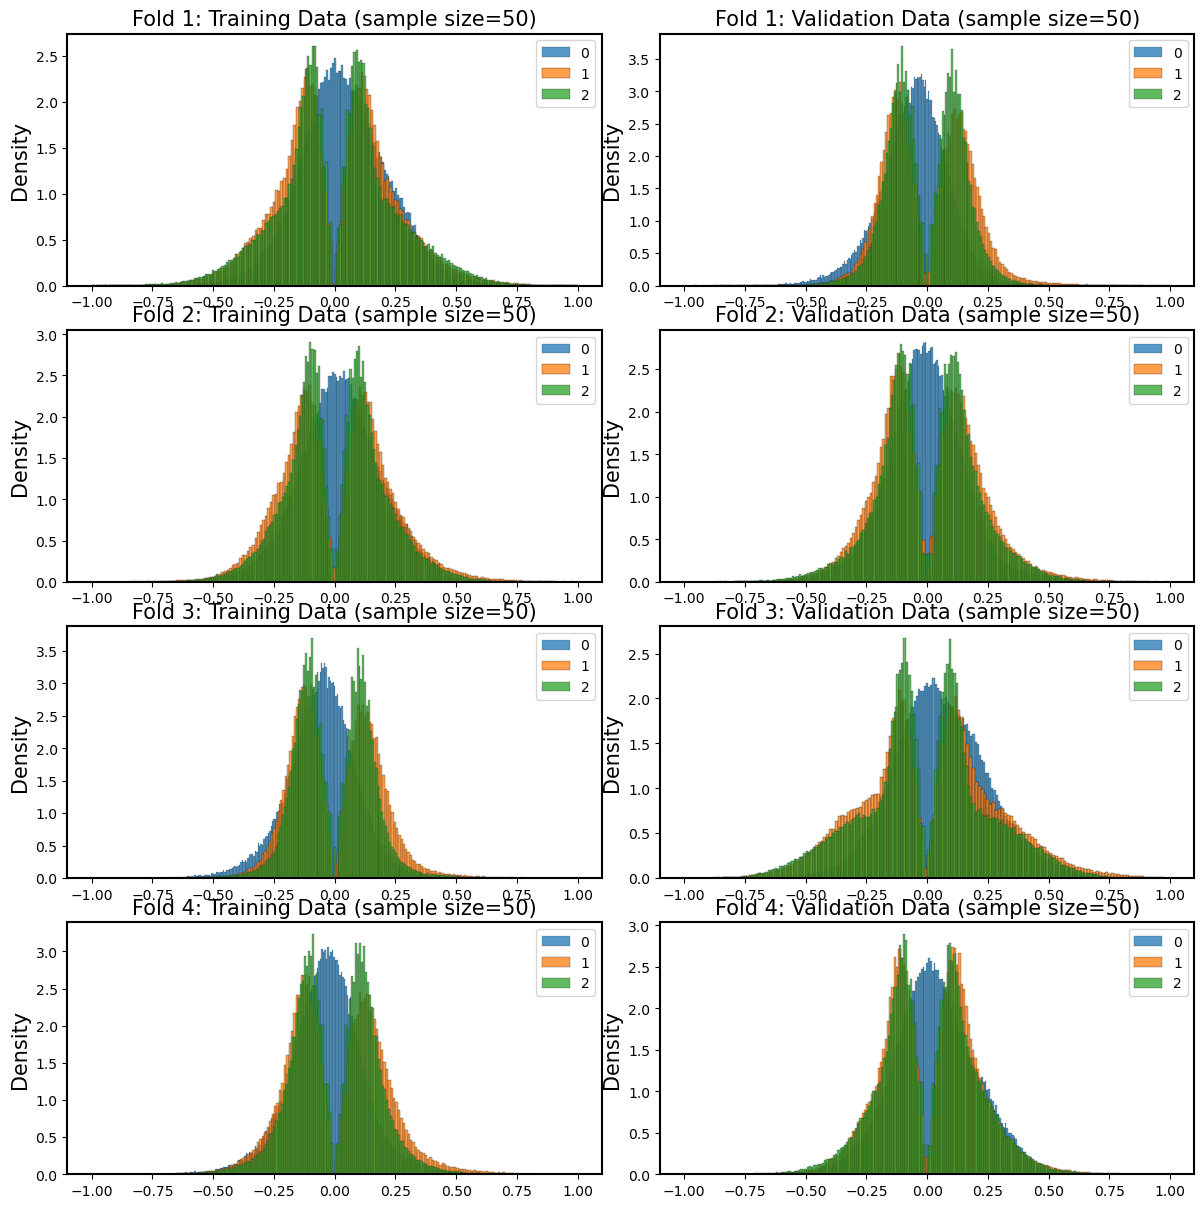

In [11]:
fig, axs = plt.subplots(nfolds, 2, figsize=(12, 12))
fig.tight_layout()
np.seterr(divide='ignore', invalid='ignore')
for fold_idx in range(nfolds):
    # Get data splits
    test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
        test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
    )
    print(f'Fold {fold_idx + 1}')
    np.random.shuffle(train_idx)
    np.random.shuffle(val_idx)
    nrows, ncols = 5, 10
    
    get_pixel_dist(
        train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
        nsamples=200, ax=axs[fold_idx][0], idx_to_plot=0
    )
    get_pixel_dist(
        train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
        nsamples=200, ax=axs[fold_idx][0], idx_to_plot=1
    )
    get_pixel_dist(
        train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
        nsamples=200, ax=axs[fold_idx][0], idx_to_plot=2
    )

    get_pixel_dist(
        test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
        nsamples=200, ax=axs[fold_idx][1], idx_to_plot=0
    )
    get_pixel_dist(
        test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
        nsamples=200, ax=axs[fold_idx][1], idx_to_plot=1
    )
    get_pixel_dist(
        test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
        nsamples=200, ax=axs[fold_idx][1], idx_to_plot=2
    )
    
    # get_dataset_preview(
    #     train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
    #     nrows=nrows, ncols=ncols, ax=axs[fold_idx][0], idx_to_plot=0
    # )
    # get_dataset_preview(
    #     test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
    #     nrows=nrows, ncols=ncols, ax=axs[fold_idx][1], idx_to_plot=1
    # )
plt.show(fig)
plt.close()

In [12]:
learning_rate = 0.001
weight_decay = 1e-5
epochs = 15
# nfolds = 8
gamma = 0.9
def do_cross_validation(test_prop, nfolds):
    test_loader = None
    validation_accuracies = []
    trainers = []
    dsl = train_labeled_data.dsl_df
    try:
        for fold_idx in range(nfolds):
            # Get data splits
            test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
                test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
            )
            # Make dataloaders
            train_loader = torch.utils.data.DataLoader(
              dataset=train_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.SubsetRandomSampler(train_idx)
            )
            
            val_loader = torch.utils.data.DataLoader(
              dataset=test_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
            )
            if test_loader is None:
                test_loader = torch.utils.data.DataLoader(
                  dataset=test_labeled_data,
                  batch_size=batch_size,
                  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
                )

            # Create model
            model = CloudDetection()
            # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            loss_fn = nn.CrossEntropyLoss()
            
            trainer = Trainer(
                model, optimizer, loss_fn, train_loader, val_loader,
                epochs=epochs, gamma=gamma, do_summary=False,
                # img_type=img_type
            )
            print(f'Doing Fold {fold_idx + 1} of {nfolds}')
            trainer.train(make_train_logs=True, write_plots=False, fold_idx=fold_idx + 1)

            # Print stats
            print(f'Fold {fold_idx + 1} Class Stats')
            print_class_dist(dsl, test_idx, 'test')
            print_class_dist(dsl, val_idx, 'val')
            print_class_dist(dsl, train_idx, 'train')
            print_class_dist(dsl, dsl.index, 'overall')

            data_fig, data_axs = plt.subplots(1, 2, figsize=(12,24))
            data_fig.tight_layout()
            nrows, ncols = 15, 30
            get_dataset_preview(
                train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
                nrows=nrows, ncols=ncols, ax=data_axs[0]
            )
            get_dataset_preview(
                test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
                nrows=nrows, ncols=ncols, ax=data_axs[1]
            )
            plt.show(data_fig)
            plt.close(data_fig)
            
            average_validation_accuracies_in_last_5_epochs = trainer.training_log['val']['acc'][-5:]
            validation_accuracies.append(average_validation_accuracies_in_last_5_epochs)
    
            # Cleanup
            trainer.model.to('cpu')
            trainers.append(trainer)
    except Exception as e:
        raise e
    finally:
        print(f'Average validation accuracy: {np.mean(validation_accuracies)}')
        return validation_accuracies, trainers

Doing Fold 1 of 4


Epoch 1


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.7346,  acc = 690/1463 (47.16%) 
      Train: 	loss = 0.6888,  acc = 1418/2939 (48.25%)


Epoch 2


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.7222,  acc = 698/1463 (47.71%) 
      Train: 	loss = 0.5991,  acc = 2090/2939 (71.11%)


Epoch 3


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.7115,  acc = 724/1463 (49.49%) 
      Train: 	loss = 0.5492,  acc = 2242/2939 (76.28%)


Epoch 4


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.6523,  acc = 837/1463 (57.21%) 
      Train: 	loss = 0.4804,  acc = 2631/2939 (89.52%)


Epoch 5


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.6405,  acc = 851/1463 (58.17%) 
      Train: 	loss = 0.4741,  acc = 2641/2939 (89.86%)


Epoch 6


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.6172,  acc = 910/1463 (62.20%) 
      Train: 	loss = 0.4622,  acc = 2687/2939 (91.43%)


Epoch 7


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5968,  acc = 1004/1463 (68.63%) 
      Train: 	loss = 0.4415,  acc = 2790/2939 (94.93%)


Epoch 8


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.6127,  acc = 960/1463 (65.62%) 
      Train: 	loss = 0.4207,  acc = 2759/2939 (93.88%)


Epoch 9


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5514,  acc = 1092/1463 (74.64%) 
      Train: 	loss = 0.4101,  acc = 2813/2939 (95.71%)


Epoch 10


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5830,  acc = 995/1463 (68.01%) 
      Train: 	loss = 0.4031,  acc = 2771/2939 (94.28%)


Epoch 11


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5480,  acc = 1065/1463 (72.80%) 
      Train: 	loss = 0.3968,  acc = 2789/2939 (94.90%)


Epoch 12


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5497,  acc = 1061/1463 (72.52%) 
      Train: 	loss = 0.3830,  acc = 2802/2939 (95.34%)


Epoch 13


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5620,  acc = 1048/1463 (71.63%) 
      Train: 	loss = 0.3997,  acc = 2788/2939 (94.86%)


Epoch 14


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5682,  acc = 1047/1463 (71.57%) 
      Train: 	loss = 0.4020,  acc = 2794/2939 (95.07%)


Epoch 15


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5310,  acc = 1105/1463 (75.53%) 
      Train: 	loss = 0.3844,  acc = 2819/2939 (95.92%)
Done training
1


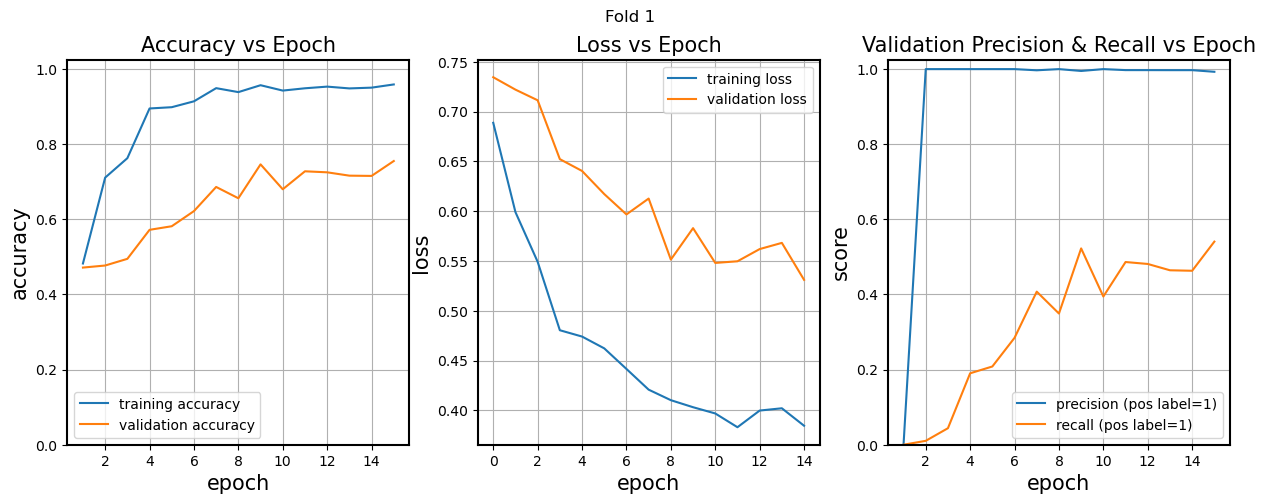

Fold 1 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 52.837% (773 / 1463); Unique module_ids: [1, 254]
Percent cloudy (in train) = 56.448% (1659 / 2939); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


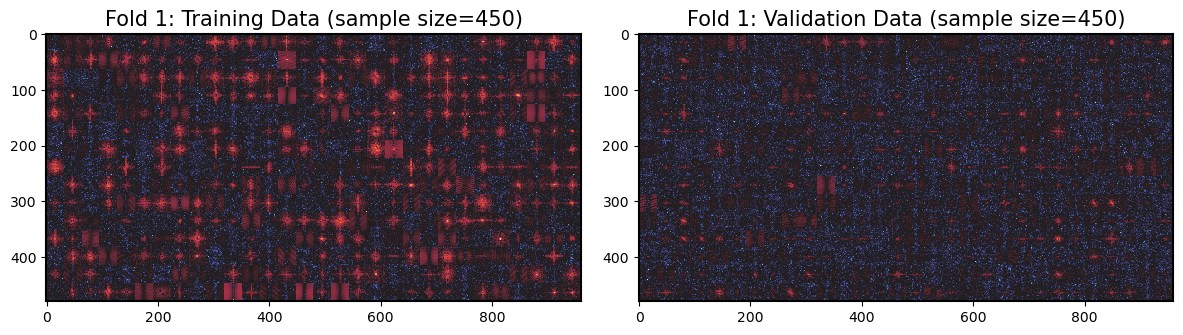

Doing Fold 2 of 4


Epoch 1


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.8179,  acc = 651/1463 (44.50%) 
      Train: 	loss = 0.7965,  acc = 676/1476 (45.80%)


Epoch 2


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.7573,  acc = 651/1463 (44.50%) 
      Train: 	loss = 0.7354,  acc = 676/1476 (45.80%)


Epoch 3


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.7750,  acc = 651/1463 (44.50%) 
      Train: 	loss = 0.7219,  acc = 677/1476 (45.87%)


Epoch 4


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.7291,  acc = 725/1463 (49.56%) 
      Train: 	loss = 0.6816,  acc = 724/1476 (49.05%)


Epoch 5


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.7098,  acc = 735/1463 (50.24%) 
      Train: 	loss = 0.6739,  acc = 744/1476 (50.41%)


Epoch 6


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6725,  acc = 808/1463 (55.23%) 
      Train: 	loss = 0.6236,  acc = 816/1476 (55.28%)


Epoch 7


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6655,  acc = 846/1463 (57.83%) 
      Train: 	loss = 0.6234,  acc = 828/1476 (56.10%)


Epoch 8


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6882,  acc = 823/1463 (56.25%) 
      Train: 	loss = 0.6226,  acc = 814/1476 (55.15%)


Epoch 9


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6443,  acc = 924/1463 (63.16%) 
      Train: 	loss = 0.5882,  acc = 939/1476 (63.62%)


Epoch 10


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6455,  acc = 942/1463 (64.39%) 
      Train: 	loss = 0.5493,  acc = 1004/1476 (68.02%)


Epoch 11


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6477,  acc = 943/1463 (64.46%) 
      Train: 	loss = 0.5466,  acc = 992/1476 (67.21%)


Epoch 12


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6473,  acc = 943/1463 (64.46%) 
      Train: 	loss = 0.5498,  acc = 998/1476 (67.62%)


Epoch 13


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6434,  acc = 956/1463 (65.35%) 
      Train: 	loss = 0.5463,  acc = 1044/1476 (70.73%)


Epoch 14


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6525,  acc = 938/1463 (64.11%) 
      Train: 	loss = 0.5593,  acc = 978/1476 (66.26%)


Epoch 15


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6455,  acc = 956/1463 (65.35%) 
      Train: 	loss = 0.5438,  acc = 1030/1476 (69.78%)
Done training
2


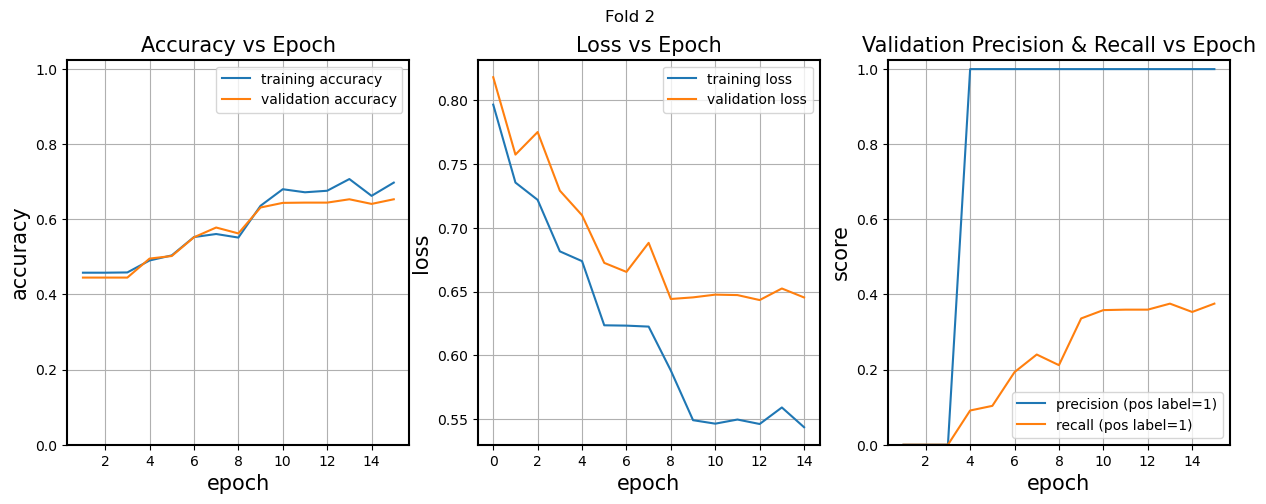

Fold 2 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 55.502% (812 / 1463); Unique module_ids: [1, 254]
Percent cloudy (in train) = 54.201% (800 / 1476); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


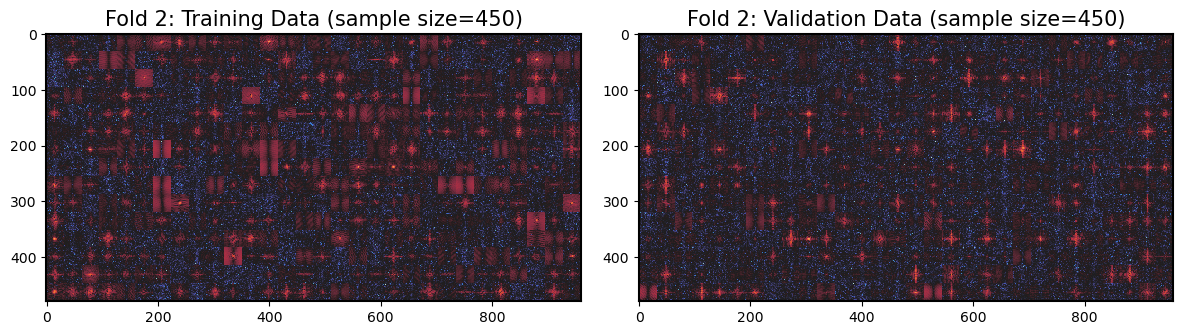

Doing Fold 3 of 4


Epoch 1


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.7248,  acc = 604/1463 (41.29%) 
      Train: 	loss = 0.7094,  acc = 699/1476 (47.36%)


Epoch 2


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.7311,  acc = 506/1463 (34.59%) 
      Train: 	loss = 0.7073,  acc = 592/1476 (40.11%)


Epoch 3


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.7204,  acc = 376/1463 (25.70%) 
      Train: 	loss = 0.7034,  acc = 525/1476 (35.57%)


Epoch 4


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6888,  acc = 732/1463 (50.03%) 
      Train: 	loss = 0.7012,  acc = 699/1476 (47.36%)


Epoch 5


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.7025,  acc = 718/1463 (49.08%) 
      Train: 	loss = 0.6916,  acc = 744/1476 (50.41%)


Epoch 6


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6936,  acc = 786/1463 (53.73%) 
      Train: 	loss = 0.6802,  acc = 975/1476 (66.06%)


Epoch 7


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6646,  acc = 867/1463 (59.26%) 
      Train: 	loss = 0.6753,  acc = 784/1476 (53.12%)


Epoch 8


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6779,  acc = 933/1463 (63.77%) 
      Train: 	loss = 0.6803,  acc = 830/1476 (56.23%)


Epoch 9


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6858,  acc = 897/1463 (61.31%) 
      Train: 	loss = 0.6818,  acc = 958/1476 (64.91%)


Epoch 10


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6844,  acc = 834/1463 (57.01%) 
      Train: 	loss = 0.6826,  acc = 807/1476 (54.67%)


Epoch 11


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6629,  acc = 1148/1463 (78.47%) 
      Train: 	loss = 0.6819,  acc = 831/1476 (56.30%)


Epoch 12


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6585,  acc = 1188/1463 (81.20%) 
      Train: 	loss = 0.6772,  acc = 864/1476 (58.54%)


Epoch 13


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6635,  acc = 1168/1463 (79.84%) 
      Train: 	loss = 0.6766,  acc = 988/1476 (66.94%)


Epoch 14


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6569,  acc = 1258/1463 (85.99%) 
      Train: 	loss = 0.6736,  acc = 1174/1476 (79.54%)


Epoch 15


  0%|          | 0/24 [00:00<?, ?batches/s]

       Val: 	loss = 0.6740,  acc = 1054/1463 (72.04%) 
      Train: 	loss = 0.6760,  acc = 1113/1476 (75.41%)
Done training
3


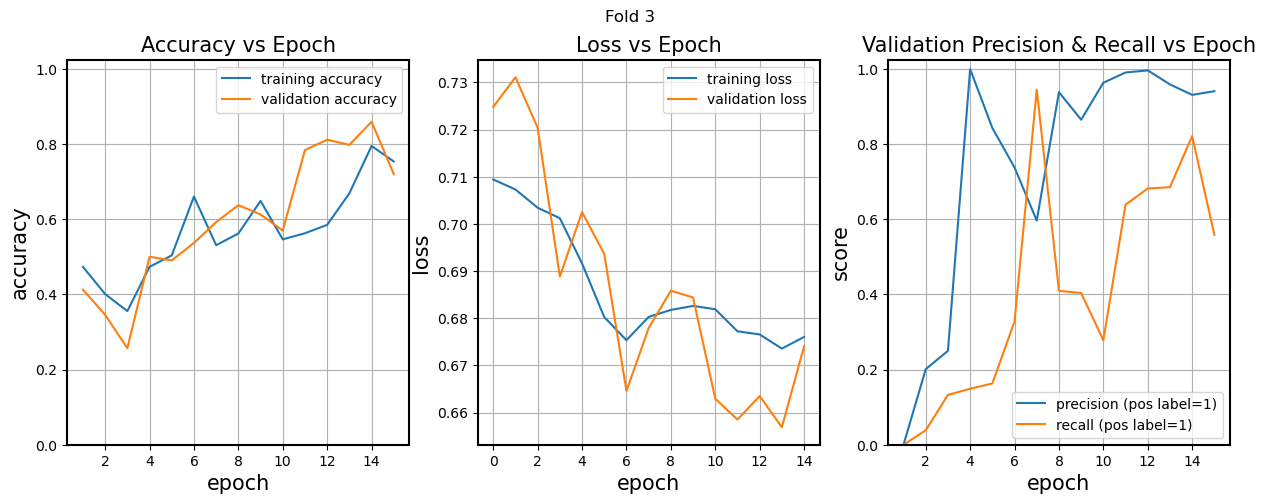

Fold 3 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 58.715% (859 / 1463); Unique module_ids: [1, 254]
Percent cloudy (in train) = 52.642% (777 / 1476); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


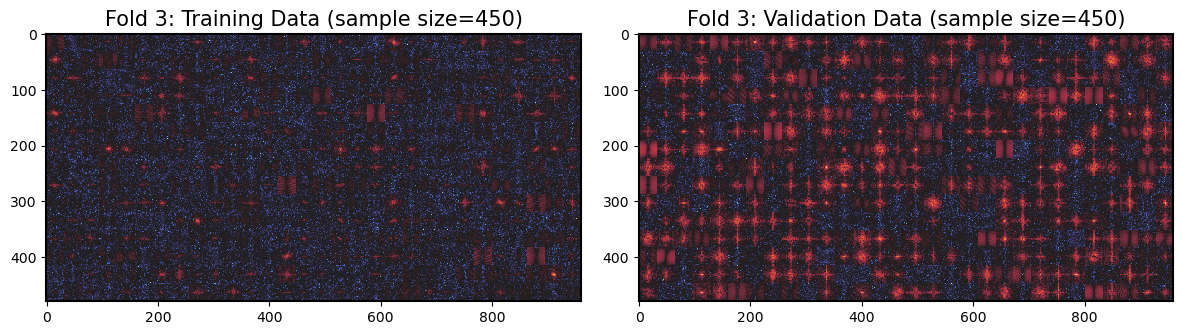

Doing Fold 4 of 4


Epoch 1


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.6966,  acc = 642/1463 (43.88%) 
      Train: 	loss = 0.6939,  acc = 1368/2926 (46.75%)


Epoch 2


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.6653,  acc = 878/1463 (60.01%) 
      Train: 	loss = 0.6779,  acc = 1633/2926 (55.81%)


Epoch 3


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5963,  acc = 1178/1463 (80.52%) 
      Train: 	loss = 0.6332,  acc = 1819/2926 (62.17%)


Epoch 4


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5729,  acc = 1280/1463 (87.49%) 
      Train: 	loss = 0.5953,  acc = 2182/2926 (74.57%)


Epoch 5


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.5279,  acc = 1278/1463 (87.35%) 
      Train: 	loss = 0.5468,  acc = 2393/2926 (81.78%)


Epoch 6


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.4659,  acc = 1357/1463 (92.75%) 
      Train: 	loss = 0.4891,  acc = 2621/2926 (89.58%)


Epoch 7


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.4861,  acc = 1352/1463 (92.41%) 
      Train: 	loss = 0.4989,  acc = 2661/2926 (90.94%)


Epoch 8


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.4464,  acc = 1364/1463 (93.23%) 
      Train: 	loss = 0.4648,  acc = 2677/2926 (91.49%)


Epoch 9


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.4323,  acc = 1354/1463 (92.55%) 
      Train: 	loss = 0.4562,  acc = 2668/2926 (91.18%)


Epoch 10


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.4068,  acc = 1359/1463 (92.89%) 
      Train: 	loss = 0.4346,  acc = 2674/2926 (91.39%)


Epoch 11


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.3972,  acc = 1365/1463 (93.30%) 
      Train: 	loss = 0.4185,  acc = 2685/2926 (91.76%)


Epoch 12


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.4118,  acc = 1361/1463 (93.03%) 
      Train: 	loss = 0.4286,  acc = 2675/2926 (91.42%)


Epoch 13


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.4012,  acc = 1369/1463 (93.57%) 
      Train: 	loss = 0.4280,  acc = 2693/2926 (92.04%)


Epoch 14


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.3965,  acc = 1375/1463 (93.98%) 
      Train: 	loss = 0.4264,  acc = 2696/2926 (92.14%)


Epoch 15


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.3948,  acc = 1375/1463 (93.98%) 
      Train: 	loss = 0.4216,  acc = 2696/2926 (92.14%)
Done training
4


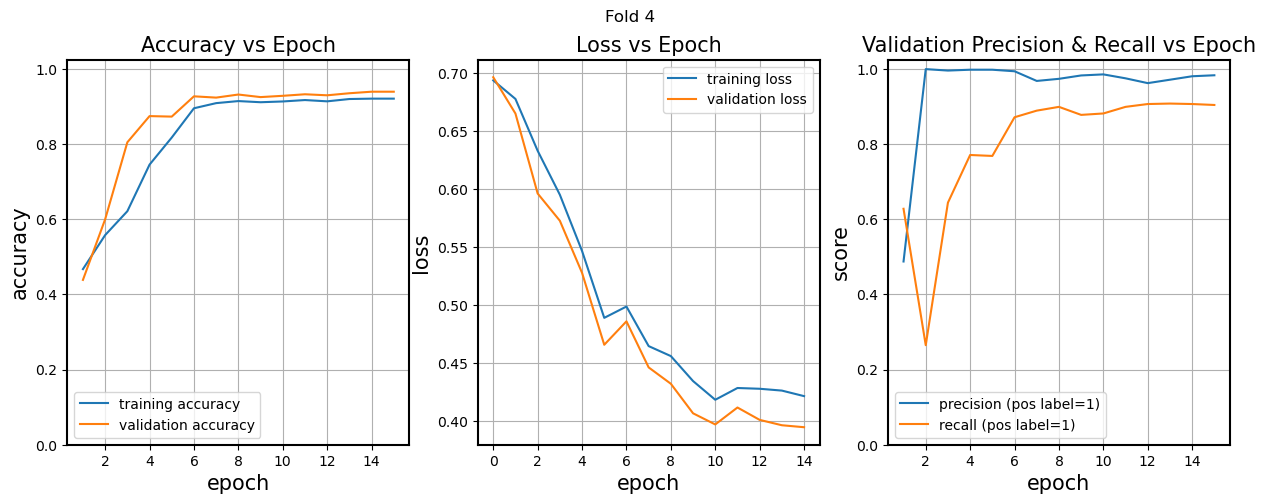

Fold 4 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 54.409% (796 / 1463); Unique module_ids: [1, 254]
Percent cloudy (in train) = 54.170% (1585 / 2926); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


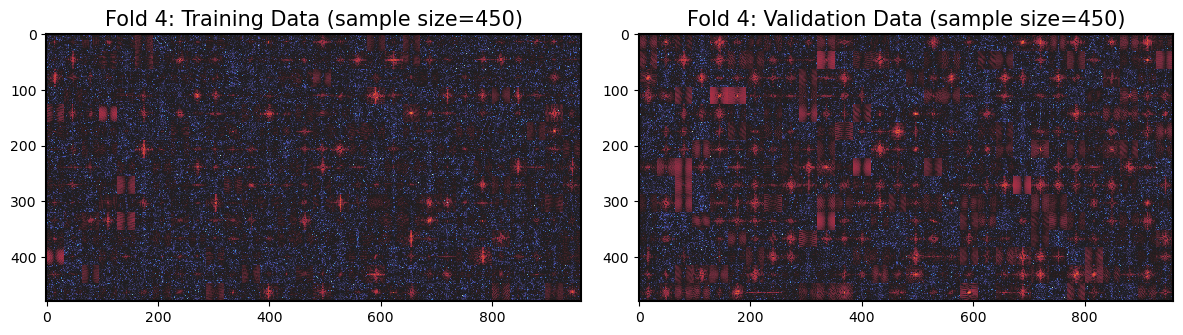

Average validation accuracy: 0.7765892002734107


In [13]:
validation_accuracies, trainers = do_cross_validation(test_prop, nfolds)

In [351]:
# Train full model

test_prop = 0.3
nfolds = 1
boundary_prop = 0.1 # Proportion of data to discard between the validation and train_proportions (time)
batch_size = 128

test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
    test_prop, boundary_prop, test_module_ids=[3], fold_idx=0, nfolds=nfolds
)

# test_idx, val_idx, train_idx = get_shuffled_test_val_train_indices(test_prop, 0)
# print(test_idx, val_idx, train_idx)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop (of dataset) = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop (of trainset)= {100 * len(train_idx) / (len(val_idx) + len(train_idx)):.2f}%\n'
      f'val_prop (of trainset) = {100 * len(val_idx) / (len(val_idx) + len(train_idx)):.2f}%'
)
# feature_uid = train_labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# train_labeled_data[0][0]


print_class_dist(dsl, test_idx, 'test')
print_class_dist(dsl, val_idx, 'val')
print_class_dist(dsl, train_idx, 'train')
print_class_dist(dsl, dsl.index, 'overall')
print(len(val_idx) / (len(val_idx) + len(train_idx)))
print(min(val_idx))




# Training config
learning_rate = 0.001
weight_decay = 1e-5
epochs = 30
gamma = 0.9
# momentum=0.9

model = CloudDetection()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()


trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=epochs, gamma=gamma, do_summary=True,
    # img_type=img_type
);
gc.collect();


test_prop (of dataset) = 33.34%
train_prop (of trainset)= 88.98%
val_prop (of trainset) = 11.02%
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 49.141% (286 / 582); Unique module_ids: [1, 254]
Percent cloudy (in train) = 55.712% (2619 / 4701); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]
0.11016467915956843
0
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 27, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 27, 32, 32]          270
|    └─ReLU: 2-2                         [-1, 27, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 27, 32, 32]          54
|    └─Dropout2d: 2-4                    [-1, 27, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 27, 32, 32]          2,214
|    └─ReLU: 2-6                         [-1, 27, 32, 32]          --
|



Epoch 1


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6891,  acc = 296/582 (50.86%) 



Epoch 2


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6574,  acc = 349/582 (59.97%) 



Epoch 3


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6168,  acc = 493/582 (84.71%) 



Epoch 4


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5672,  acc = 488/582 (83.85%) 



Epoch 5


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5390,  acc = 507/582 (87.11%) 



Epoch 6


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5013,  acc = 517/582 (88.83%) 



Epoch 7


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5083,  acc = 536/582 (92.10%) 



Epoch 8


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4743,  acc = 538/582 (92.44%) 



Epoch 9


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4420,  acc = 542/582 (93.13%) 



Epoch 10


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4484,  acc = 543/582 (93.30%) 



Epoch 11


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4386,  acc = 551/582 (94.67%) 



Epoch 12


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4159,  acc = 551/582 (94.67%) 



Epoch 13


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4506,  acc = 546/582 (93.81%) 



Epoch 14


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4101,  acc = 554/582 (95.19%) 



Epoch 15


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4229,  acc = 553/582 (95.02%) 



Epoch 16


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4063,  acc = 553/582 (95.02%) 



Epoch 17


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.3981,  acc = 556/582 (95.53%) 



Epoch 18


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4079,  acc = 557/582 (95.70%) 



Epoch 19


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4157,  acc = 559/582 (96.05%) 



Epoch 20


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4140,  acc = 555/582 (95.36%) 



Epoch 21


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4082,  acc = 559/582 (96.05%) 



Epoch 22


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4026,  acc = 559/582 (96.05%) 



Epoch 23


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.3971,  acc = 559/582 (96.05%) 



Epoch 24


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.3930,  acc = 560/582 (96.22%) 



Epoch 25


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.3898,  acc = 559/582 (96.05%) 



Epoch 26


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.3842,  acc = 559/582 (96.05%) 



Epoch 27


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.3835,  acc = 560/582 (96.22%) 



Epoch 28


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.3854,  acc = 560/582 (96.22%) 



Epoch 29


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.3863,  acc = 560/582 (96.22%) 



Epoch 30


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.3867,  acc = 560/582 (96.22%) 

Done training


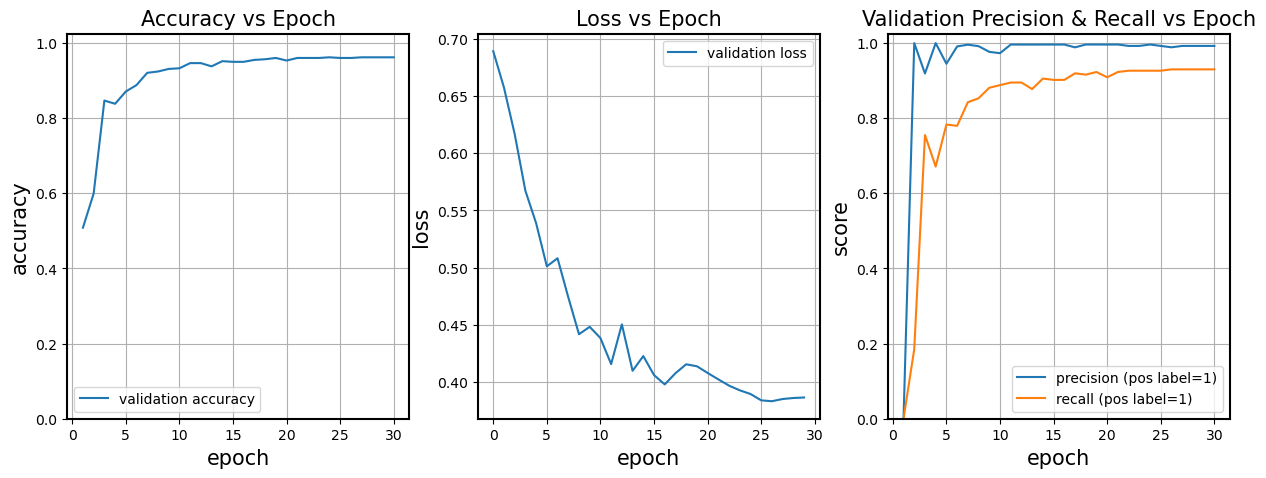

In [352]:
trainer.train(make_train_logs=False)

  0%|          | 0/23 [00:00<?, ?batches/s]

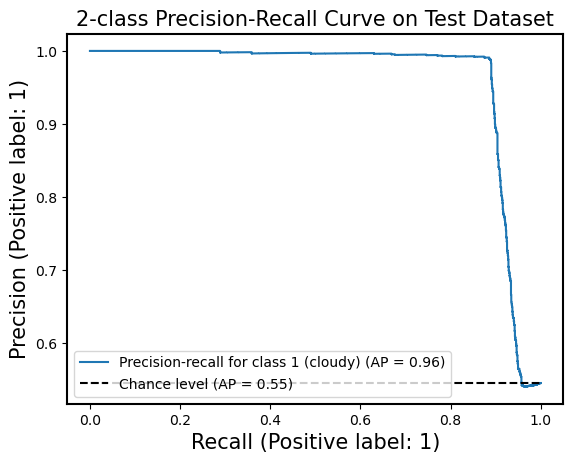

Test: 	loss = 0.3808,  acc = 2806/2934 (95.64%)


In [353]:
test_model = CloudDetection()
test_model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth', weights_only=True))
loss_fn = nn.CrossEntropyLoss()
tester = Tester(test_model, loss_fn, test_loader)
tester.eval()